# Inspecting pulsar frequency data

We have produced some data using the methods in `scripts/generate_frequency_timeseries.py`

Lets load this data and make sure everything looks reasonable

First, load and plot the timeseries

In [1]:
import numpy as np 

data = np.load('../output_data/sandbox/frequency_timeseries.npz')
data.files

['f_tim_file', 'f_par_file']

In [2]:
y = data['f_tim_file']

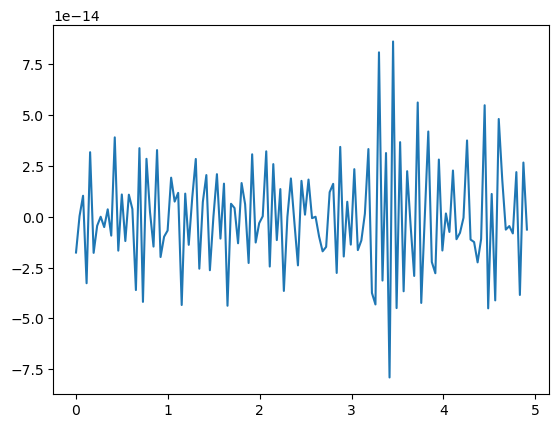

In [4]:
import matplotlib.pyplot as plt 

t = y[:,-1]
tplot = t / (365*24*3600)
f = y[:,0]
plt.plot(tplot,f)


Looks reasonable. Remember that we have subtracted off the trend.

To add back on the trend, we need the par file:

In [6]:
parameter_file = data['f_par_file']
f0  = parameter_file[0,:]
f1  = parameter_file[1,:]
DEC = parameter_file[2,:]
RA  = parameter_file[3,:]

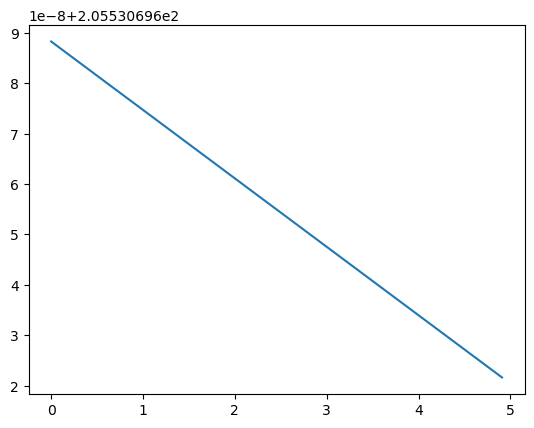

In [7]:
psr_idx = 0
f_secular = f0[psr_idx] + f1[psr_idx]*t + y[:,psr_idx]
plt.plot(tplot,f_secular)

also looks reasonable...


Lets check out the RA and DEC too:

In [31]:
import matplotlib.pyplot as plt
import scienceplots
from mw_plot import mw_radec
plt.style.use('science')


def convert_ra(x,org):


    xnew = np.remainder(x+360-org,360) # shift RA values
    ind = xnew>180
    xnew[ind] -=360    # scale conversion to [-180, 180]
    xnew=-xnew    # reverse the scale: East to the left

    return xnew

def degrees_to_hours(x):


    return x/15.0

def plot_mwd(RA,Dec,d,org=0, projection='mollweide',cmap='viridis',savefig=None):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    modified from https://balbuceosastropy.blogspot.com/2013/09/the-mollweide-projection.html
    '''
    
    
    x = convert_ra(RA,org)

    #Setup the figure
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection)

    fs = 20
    
    
    #Plot the pulsars
    sc = ax.scatter(np.radians(x),np.radians(Dec),c=d,cmap=cmap)  # convert degrees to radians


    #Colorbar of distance
    cbar = plt.colorbar(sc,orientation='horizontal',fraction=0.06, pad=0.075,cmap=cmap)
    cbar.ax.set_xlabel('d [kpc]', rotation=0,fontsize=fs)



    mw_plane_ra, mw_plane_dec = mw_radec(deg=True)  # RA/DEC arrays of milkyway plane in degs
    mw_plane_ra = convert_ra(mw_plane_ra,org)
    ax.plot(np.radians(mw_plane_ra),np.radians(mw_plane_dec),c='0.5', linestyle='--')  # convert degrees to radians


    #Formatting
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    tick_labels = degrees_to_hours(tick_labels)

    string_tick_labels = [str(int(i))+'h' for i in tick_labels]
    ax.set_xticklabels(string_tick_labels)     # we add the scale on the x axis


    #ax.set_xlabel("Right Ascension",fontsize=fs)
    #ax.set_ylabel("Declination", fontsize=fs)
    ax.xaxis.set_tick_params(labelsize=fs-4)
    ax.yaxis.set_tick_params(labelsize=fs-4)
    cbar.ax.xaxis.set_tick_params(labelsize=fs-4)
    cbar.ax.xaxis.set_major_locator(plt.MaxNLocator(7))


    
    ax.grid(True)



    if savefig != None:
        plt.savefig(f"../data/images/{savefig}.png", bbox_inches="tight",dpi=300)


    plt.show()


RA limits: 1370.5724722662992 62871.92792482594
RA_x limits: -175.66932195165282 167.4432927746093
DEC limits: -1.2573773650910538 0.9270732718741476


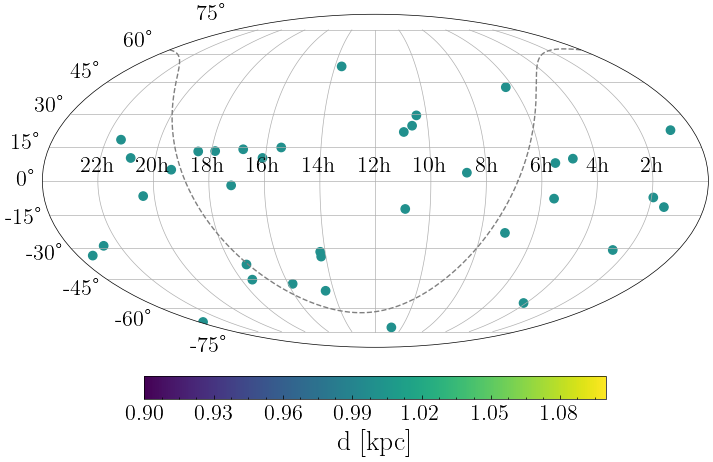

In [30]:
d = np.ones(len(RA))
RA_deg = RA*180.0/np.pi
DEC_deg = DEC*180.0/np.pi

plot_mwd(RA_deg*180,DEC_deg,d,org=180, projection='mollweide',savefig=None)